# Image and Coordinates Registration with Rigid/ Affine & TPS Transformation


This Jupyter Notebook serves as a comprehensive guide to use the python functions intended for Professor Lee Chi-Hon's lab. These functions are specifically tailored for conducting landmark-oriented rigid, affine and TPS transformations on Drosophila 

Should you encounter any points that remain ambiguous or require further elucidation, kindly reach out via email to: cyh37@cam.ac.uk.

## Before you start

Before you begin, it's crucial to configure your environment correctly to ensure smooth execution. Here are the essential steps you need to follow:

1. Python Library Installation: You need to install specific Python libraries to effectively run the script. Please refer to the details provided in the environment.yml file. This file outlines the required Python libraries and their versions. To create an environment with the provided yml file, follow the instructions outlined here: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

2. Java Development Kit (JDK) Installation (**Optional**): The primary purpose of this is to facilitate the reading of IDS files in the Python script. **If you have all the volume data in the tif format, this is not required.** To enable Python to interact with the Java environment, it's necessary to download Java SE Development Kits with a version greater than 11.0. You can obtain the required JDK download from this link: https://www.oracle.com/java/technologies/downloads/#java11.





## User inputs
The script work in the way that we assume there are all the necessary files (\*.ics, \*.csv, \*iv or \*swc, \*ids or \*tif) in one folder ```home_directory```, and the script will proceed according to what is there, i.e.,
```
home_directory
|
├─ *.ics (For pixel size reading)
├─ *.csv (For control coordinates)
├─ *.tif OR/AND *.ids (Image volume)
└─ *.iv OR/AND *.swc (Neurites coordinates)
```

```target_coord_path``` is the full path to the target coordinate file (\*.csv)

```transform_type``` can be either 'rigid' or 'affine'

```do_tps``` set this to ```True``` if TPS transform is desired. If not, set it to ```False```

```image_bin_factor``` is the factors for binning the image for transformation. If set to 2, 2^3 pixels will combine into one pixel for calculation. This reduces the computational speed, for reduced image quality, but the quality of the coordinates registration is unchanged

The option ```align_target_coord``` allows you to align the target coordinates with control coordinates before the transformation. If you choose not to align them, while the coordinate files (such as the SWC file) will be transformed without any problems, certain parts of the transformed image volume might be missing. This happens because the image volume will shift in a way that the control coordinates overlap with the target coordinates. As a result of this shift, some parts of the image volume will move away from the intended volume boundary.

To prevent this, you can set it to ```True``` to align the target coordinates by performing a rigid transformation towards the control coordinates before initiating the image registration process. This alignment ensures that during the image registration, the image volume won't shift significantly beyond the predefined volume boundary. If your objective is solely to register the SWC coordinates, it's recommended to set this option to ```False```.

```napari_display``` If this is set to ```True```, the results will be displayed with Napari at the end of computation

In [1]:
home_directory = r"D:\drosophila_visual_trace_data\Toll 9_7_RV"
target_coord_path = r"D:\drosophila_visual_trace_data\target_coordinates\target_coordinates_RV.csv"
transform_type = 'affine'  # Must be 'affine' or 'rigid'
do_tps = True
image_bin_factor = 2  # Factors for binning the image for transformation
align_target_coord = True
napari_display = True

## Import necessary functions and libraries

In addition to the standard Python libraries used for image processing, there are two custom libraries that have been developed:

The ```utility``` library: This library contains various custom functions designed for tasks such as file management and data processing. These functions are particularly tailored for image transformation processes.

The ```iv2swc``` library: This library is equipped with functions specifically designed to facilitate the conversion of the IV format to the SWC format. This conversion functionality streamlines the process of translating between these two formats.

In [2]:
from skimage.io import imread, imsave
from utility import find_files, get_pixel_size, scale_image, get_axon_dendrite_for_napari, read_coord_csv, \
    um_to_pixel, get_transform_matrix, linear_transform_image, linear_transform_coord, linear_transform_swc, \
    make_directory, pixel_to_um, write_coord_csv, downsample, tps_transform_image, tps_transform_swc, save_image
from iv2swc import iv2swc
import numpy as np
import napari
import os

## Data loading and preprocessing

Please refer to the explanatory comments within the code to understand the purpose of each step.

All the transformed data will be saved in ```transformed_results``` directory in the ```home_directory```

It's important to note that all values have been converted to pixel units for processing purposes.

Additionally, all coordinates have been transformed into ZYX format for processing. This might seem counterintuitive, but in Python, especially with libraries like numpy and scikit-image, the convention is that images are organized in the ZYX format. You can find more information on this convention in the reference provided here: https://forum.image.sc/t/3d-view-coordinate-system-is-left-handed/66995

For details about the data format used for the SWC file, please visit this link: http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html

In [3]:
# Create a directory to save all the transformed results
transformed_results_dir = os.path.join(home_directory, 'transformed_results')
make_directory(transformed_results_dir)

# Find all the necessary files
ics_file_path = find_files(home_directory, '.ics')
csv_file_path = find_files(home_directory, '.csv')
iv_file_path  = find_files(home_directory, '.iv')
swc_file_path = find_files(home_directory, '.swc')
ids_file_path = find_files(home_directory, '.ids')
tif_file_path = find_files(home_directory, '.tif')

## Read image file
# if tif does not exist, it will assume that ids exists, and will convert ids to tif and save
if tif_file_path is None:
    from read_ids import read_ids
    print("Converting IDS to TIF ...")
    image = read_ids(ids_file_path)
    # Save the ids file as tif
    imsave(ids_file_path[:-4] + '.tif', image)
    tif_file_path = find_files(home_directory, '.tif')
else:
    # Read tif file
    image = imread(tif_file_path)
    image = np.transpose(image,(0,2,3,1)) # Image J saves image in the format ZCYX however in scikit image processed as ZYXC

## Get pixel size, and downsample if needed (Optional)
# Get pixel size
pixel_size = get_pixel_size(ics_file_path)
# Scale pixel size by the downsample bin factor
pixel_size = pixel_size * image_bin_factor
# Down sample the image
image = downsample(image, image_bin_factor)
# Scale the original image such that all axis have the save pixel size
image_scaled, pixel_size = scale_image(image, pixel_size)

## if swc file does not exist, convert iv to swc
if swc_file_path is None:
    swc_file_path = iv2swc(iv_file_path)

# # Convert swc file to Napari displayable format
# axon, dendrite = get_axon_dendrite_for_napari(swc_file_path, pixel_size)

## Read control and target coordinates in csv file, and convert both from um to pixels
control_coord = read_coord_csv(csv_file_path)
target_coord = read_coord_csv(target_coord_path)
control_coord_pixels = um_to_pixel(control_coord, pixel_size)
target_coord_pixels = um_to_pixel(target_coord, pixel_size)


D:\drosophila_visual_trace_data\Toll 9_7_RV\transformed_results  already exists
.ics  file found:  Toll 9_7_RV.ics
.csv  file found:  Toll 9_7_RV.csv
.iv  file found:  Toll 9_7_RV.iv
.swc  file found:  Toll 9_7_RV.swc
.ids  file found:  Toll 9_7_RV.ids
.tif  file found:  Toll 9_7_RV.tif
Downsampling the image...[DONE]
Scaling images so that pixel sizes of all dimension =  0.207566 um (equivalent to x pixel size)
	Scaling for ch0...[DONE]
	Scaling for ch1...[DONE]


## Target coordinates alignment

In [4]:
if align_target_coord:
    # Get transform matrix
    transform_matrix = get_transform_matrix(control_coord_pixels, target_coord_pixels, "rigid")
    # Perform transformation
    target_coord_pixels = linear_transform_coord(target_coord_pixels, transform_matrix)
    # Save the new target coordinates results
    target_coord = pixel_to_um(target_coord_pixels, pixel_size)
    transformed_target_csv_file_path = os.path.join(transformed_results_dir, 'aligned_target_coord.csv')
    write_coord_csv(transformed_target_csv_file_path, target_coord)

Calculating the transformation matrix... [DONE]
Performing linear transformation of the given coordinates based on the transformation matrix... [DONE]


## Linear Transformation (Affine & Rigid)

Please note that the transformation matrix for coordinates registration is an inverse to that for image registration

In [5]:
## Transforming image volumes
# Get transform matrix for image transformation
transform_matrix = get_transform_matrix(control_coord_pixels, target_coord_pixels, transform_type)
# Transform image data and save results
image_LT = linear_transform_image(image_scaled, transform_matrix)
save_image(os.path.join(transformed_results_dir, transform_type + '_transformed_image.tif'), image_LT)

## Transforming coordinates
# Get transform matrix for coordinates transformation
transform_matrix = get_transform_matrix(target_coord_pixels, control_coord_pixels, transform_type)
# Transform neurites data and save results
linear_transformed_swc_path = os.path.join(transformed_results_dir, transform_type + '_transformed_neurites.swc')
linear_transform_swc(swc_file_path, transform_matrix, pixel_size, linear_transformed_swc_path)

# Transform control coord data and save results
linear_transformed_control_coord_pixels = linear_transform_coord(control_coord_pixels, transform_matrix)
linear_transformed_control_coord = pixel_to_um(linear_transformed_control_coord_pixels, pixel_size)
write_coord_csv(os.path.join(transformed_results_dir, transform_type + '_transformed_control_coord.csv'),
                linear_transformed_control_coord)

Calculating the transformation matrix... [DONE]
Performing linear transformation of a given image based on the transformation matrix: 
	Linearly transforming ch0... [DONE]
	Linearly transforming ch1... [DONE]
Calculating the transformation matrix... [DONE]
Performing linear transformation of the given neurite data based on the transformation matrix... Performing linear transformation of the given coordinates based on the transformation matrix... [DONE]
Writing  D:\drosophila_visual_trace_data\Toll 9_7_RV\transformed_results\affine_transformed_neurites.swc
[DONE]
Performing linear transformation of the given coordinates based on the transformation matrix... [DONE]


## Non-linear transformation (TPS)

In [6]:
# TPS transform the image
image_TPS, tps_fun = tps_transform_image(image_LT, linear_transformed_control_coord_pixels,
                                         target_coord_pixels)
save_image(os.path.join(transformed_results_dir, 'tps' + '_transformed_image.tif'), image_TPS)
# TPS  transform the SWC
tps_transformed_swc_path = os.path.join(transformed_results_dir, 'tps' + '_transformed_neurites.swc')
tps_transform_swc(linear_transformed_swc_path, linear_transformed_control_coord_pixels, target_coord_pixels,
                  pixel_size, tps_transformed_swc_path)

Performing TPS transformation of the given neurite data based on the tps object... Writing  D:\drosophila_visual_trace_data\Toll 9_7_RV\transformed_results\tps_transformed_neurites.swc
[DONE]


'D:\\drosophila_visual_trace_data\\Toll 9_7_RV\\transformed_results\\tps_transformed_neurites.swc'

## Display results

In [7]:
if napari_display:
    # Convert swc files to Napari displayable format
    axon, dendrite = get_axon_dendrite_for_napari(swc_file_path, pixel_size)
    axon_LT, dendrite_LT = get_axon_dendrite_for_napari(linear_transformed_swc_path, pixel_size)
    axon_TPS, dendrite_TPS = get_axon_dendrite_for_napari(tps_transformed_swc_path, pixel_size)

    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(image_scaled[:, :, :, 0])
    viewer.add_image(image_scaled[:, :, :, 1])
    viewer.add_shapes(axon, shape_type='path', edge_width=1.0, edge_color=["#ca6e38"])
    viewer.add_shapes(dendrite, shape_type='path', edge_width=1.0, edge_color=["#a7993f"])
    viewer.add_points(control_coord_pixels, size=10, face_color=["#cb5462"])

    viewer.add_image(image_LT[:, :, :, 0])
    viewer.add_image(image_LT[:, :, :, 1])
    viewer.add_shapes(axon_LT, shape_type='path', edge_width=1.0, edge_color=["#44bdc1"])
    viewer.add_shapes(dendrite_LT, shape_type='path', edge_width=1.0, edge_color=["#62b64c"])
    viewer.add_points(linear_transformed_control_coord_pixels, size=10, face_color=["#559961"])
    
    if do_tps is True:
        viewer.add_image(image_TPS[:, :, :, 0])
        viewer.add_image(image_TPS[:, :, :, 1])
        viewer.add_shapes(axon_TPS, shape_type='path', edge_width=1.0, edge_color=["#c65ea0"])
        viewer.add_shapes(dendrite_TPS, shape_type='path', edge_width=1.0, edge_color=["#6e87cc"])
        viewer.add_points(target_coord_pixels, size=10, face_color=["#9061cb"])
    napari.run()

print("DONE")

DONE


## Example results

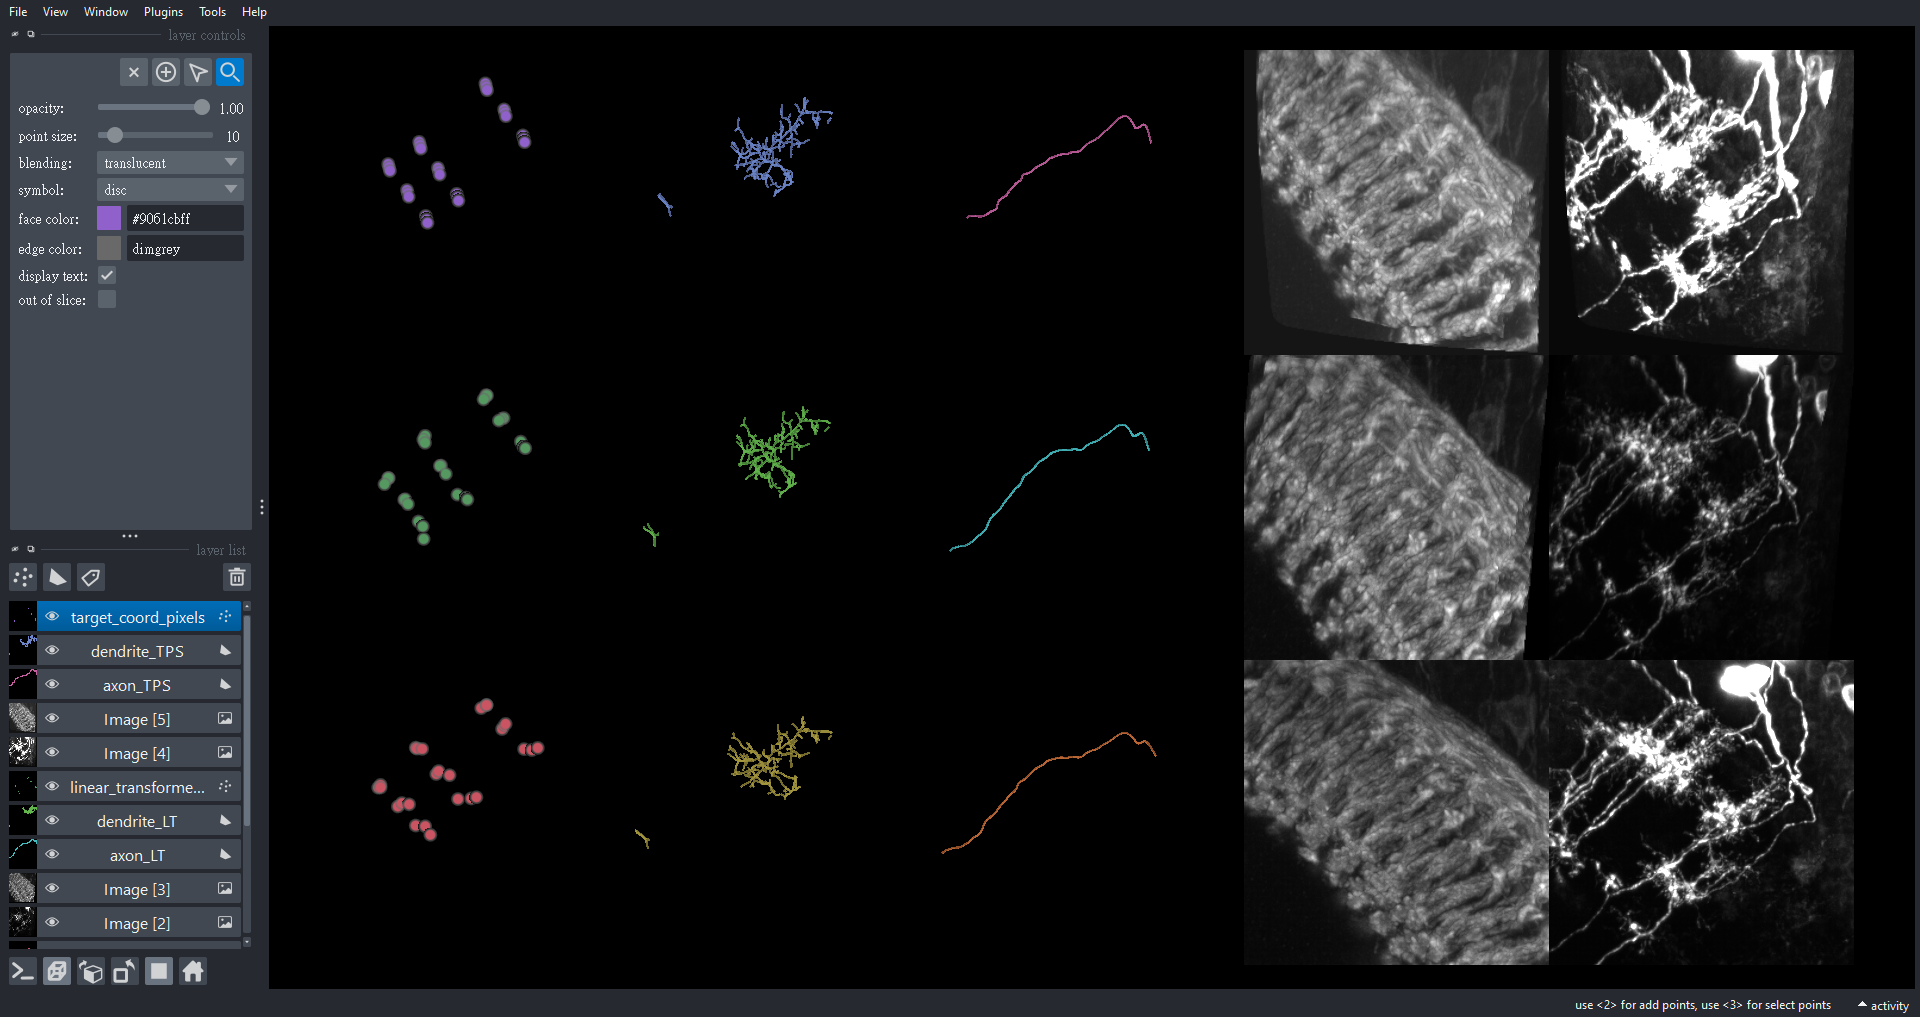

In [8]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

The last row displays the control coordinates, neurite traces, and image volume prior to the transformation. The second and first row presents these elements after affine and TPS transformations